# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.

## Задание 1. Реализация градиентного спуска (3.5 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле `descents.py`.

### Лирическое-теоретическое отступление № 1

Основное свойство антиградиента &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента,
пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (например, нулевой или сгенерированный из некоторого
случайного распределения). Тогда ванильный градиентный спуск состоит в повторении следующих шагов до сходимости:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

### Лирическое-теоретическое отступление № 2

На семинаре про [матрично-векторное дифференцирование](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem03-vector-diff.pdf) вы должны были обсуждать дифференцирование функции потерь MSE в матричном виде.

### Задание 1.0. Градиент MSE в матричном виде (0 баллов).

Напомним, что функция потерь MSE записывается в матричном виде как:

$$
    Q(w) = \dfrac{1}{\ell} \left( y - Xw \right)^T \left( y - Xw \right)
$$

Выпишите ниже (подсмотрев в семинар или решив самостоятельно) градиент для функции потерь MSE в матричном виде.

In [122]:
from __future__ import annotations

from typing import List

import numpy as np


class LinearRegression:
    """
    Linear regression class
    """

    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        """
        :param descent_config: gradient descent config
        :param tolerance: stopping criterion for square of euclidean norm of weight difference (float)
        :param max_iter: stopping criterion for iterations (int)
        """
        self.descent: BaseDescent = get_descent(descent_config)

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        """
        Fitting descent weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        old_w = self.descent.w
        self.loss_history.append(self.descent.calc_loss(x, y))
        for i in range(self.max_iter):
            if i != 0:
                self.loss_history.append(self.descent.calc_loss(x, y))
            gr = self.descent.step(x, y)
            weight = old_w + gr
            if np.sum((weight - old_w) ** 2) < self.tolerance or np.isnan(weight - old_w).any():
                break
            old_w = weight
        self.loss_history.append(self.descent.calc_loss(x, y))

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return self.descent.calc_loss(x, y)


In [185]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np


@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()


class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        # self.w: np.ndarray = np.random.rand(dimension)
        self.w: np.ndarray = np.zeros(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        # TODO: implement loss calculation function
        return np.sum((x @ self.w - y) ** 2) / x.shape[0]

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        # TODO: implement prediction function
        return x @ self.w


class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        # TODO: implement updating weights function
        t = self.lr() * gradient
        self.w -= t
        return -1 * t

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        # TODO: implement calculating gradient function
        return 2 * x.T @ (x @ self.w - y) / x.shape[0]


class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        # TODO: implement calculating gradient function
        ind = np.random.randint(0, x.shape[0], self.batch_size)
        return 2 * x[ind].T @ (x[ind] @ self.w - y[ind]) / x[ind].shape[0]


class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        # TODO: implement updating weights function
        self.h = self.alpha * self.h + self.lr() * gradient
        self.w -= self.h
        return -1 * self.h


class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        # TODO: implement updating weights function
        self.iteration += 1
        self.m = self.m * self.beta_1 + (1 - self.beta_1) * gradient
        self.v = self.v * self.beta_2 + (1 - self.beta_2) * gradient ** 2
        mk = self.m / (1 - self.beta_1 ** self.iteration)
        vk = self.v / (1 - self.beta_2 ** self.iteration)
        t = self.lr() * mk / (np.sqrt(vk) + self.eps)
        self.w -= t
        return -1 * t


class BaseDescentReg(BaseDescent):
    """
    A base class with regularization
    """

    def __init__(self, *args, mu: float = 0, **kwargs):
        """
        :param mu: regularization coefficient (float)
        """
        super().__init__(*args, **kwargs)

        self.mu = mu

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate gradient of loss function and L2 regularization with respect to weights
        """
        l2_gradient: np.ndarray = np.zeros_like(x.shape[1])  # TODO: replace with L2 gradient calculation
        without = self.w
        without[-1] = 0
        return 2 * x.T @ (x @ self.w - y) / x.shape[0] + self.mu * without


class VanillaGradientDescentReg(BaseDescentReg, VanillaGradientDescent):
    """
    Full gradient descent with regularization class
    """


class StochasticDescentReg(BaseDescentReg, StochasticDescent):
    """
    Stochastic gradient descent with regularization class
    """


class MomentumDescentReg(BaseDescentReg, MomentumDescent):
    """
    Momentum gradient descent with regularization class
    """


class AdamReg(BaseDescentReg, Adam):
    """
    Adaptive gradient algorithm with regularization class
    """


def get_descent(descent_config: dict) -> BaseDescent:
    descent_name = descent_config.get('descent_name', 'full')
    regularized = descent_config.get('regularized', False)

    descent_mapping: Dict[str, Type[BaseDescent]] = {
        'full': VanillaGradientDescent if not regularized else VanillaGradientDescentReg,
        'stochastic': StochasticDescent if not regularized else StochasticDescentReg,
        'momentum': MomentumDescent if not regularized else MomentumDescentReg,
        'adam': Adam if not regularized else AdamReg
    }

    if descent_name not in descent_mapping:
        raise ValueError(f'Incorrect descent name, use one of these: {descent_mapping.keys()}')

    descent_class = descent_mapping[descent_name]

    return descent_class(**descent_config.get('kwargs', {}))


2X^T(Xw-y)

### Задание 1.1. Родительский класс BaseDescent (0.5 балла).

Реализуйте функции `calc_loss` (вычисление MSE для переданных $x$ и $y$) и `predict` (предсказание $y_{pred}$ для переданных $x$) в классе `BaseDescent`.

Все вычисления должны быть векторизованы.

In [86]:
class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        # TODO: implement loss calculation function
        return 

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        # TODO: implement prediction function
        return self.w*x

### Задание 1.2. Полный градиентный спуск VanillaGradientDescent (0.5 балла).

Реализуйте полный градиентный спуск заполнив пропуски в классе `VanillaGradientDescent` в файле `descents.py`. Для вычисления градиента используйте формулу выше. Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

Здесь и далее функция `update_weights` должна возвращать разницу между $w_{k + 1}$ и $w_{k}$: $\quad w_{k + 1} - w_{k} = -\eta_{k} \nabla_{w} Q(w_{k})$.

Во всех методах градиентного спуска мы будем использовать следующую формулу для длины шага:

$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$

На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

In [87]:
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        # TODO: implement updating weights function
        return self.lr()*gradient

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        # TODO: implement calculating gradient function
        return 2*X.T@(X*w-y)

### Лирическое-теоретическое отступление № 3

Как правило, в задачах машинного обучения функционал $Q(w)$ представим в виде суммы $\ell$ функций:

$$
    Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        q_i(w).
$$

В нашем домашнем задании отдельные функции $q_i(w)$ соответствуют ошибкам на отдельных объектах.

Проблема метода градиентного спуска состоит в том, что на каждом шаге необходимо вычислять градиент всей суммы (будем его называть полным градиентом):

$$
    \nabla_w Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        \nabla_w q_i(w).
$$

Это может быть очень трудоёмко при больших размерах выборки. В то же время точное вычисление градиента может быть не так уж необходимо &ndash; как правило, мы делаем не очень большие шаги в сторону антиградиента, и наличие в нём неточностей не должно сильно сказаться на общей траектории.

Оценить градиент суммы функций можно средним градиентов случайно взятого подмножества функций:

$$
    \nabla_{w} Q(w_{k}) \approx \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}),
$$
где $B$ - это случайно выбранное подмножество индексов.

В этом случае мы получим метод **стохастического градиентного спуска**.

### Задание 1.3. Стохастический градиентный спуск StochasticDescent (0.5 балла).

Реализуйте стохастический градиентный спуск заполнив пропуски в классе `StochasticDescent`. Для оценки градиента используйте формулу выше (среднее градиентов случайно выбранного батча объектов). Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}).
$$

Размер батча будет являться гиперпараметром метода, семплируйте индексы для батча объектов с помощью `np.random.randint`.

### Лирическое-теоретическое отступление № 4

Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Например, если линии уровня функционала сильно вытянуты, то из-за ортогональности градиента линиям уровня он будет менять направление на почти противоположное на каждом шаге. Такие осцилляции будут вносить сильный шум в движение, и процесс оптимизации займёт много итераций. Чтобы избежать этого, можно усреднять векторы антиградиента с нескольких предыдущих шагов &ndash; в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введём для этого вектор инерции:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k})
\end{align}

Здесь $\alpha$ &ndash; параметр метода, определяющей скорость затухания градиентов с предыдущих шагов. Разумеется, вместо вектора градиента может быть использована его аппроксимация. Чтобы сделать шаг градиентного спуска, просто сдвинем предыдущую точку на вектор инерции:

$$
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

Заметим, что если по какой-то координате градиент постоянно меняет знак, то в результате усреднения градиентов в векторе инерции эта координата окажется близкой к нулю. Если же по координате знак градиента всегда одинаковый, то величина соответствующей координаты в векторе инерции будет большой, и мы будем делать большие шаги в соответствующем направлении.

### Задание 1.4 Метод Momentum MomentumDescent (0.5 балла).

Реализуйте градиентный спуск с методом инерции заполнив пропуски в классе `MomentumDescent`. Шаг оптимизации:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k}) \\
    &w_{k + 1} = w_{k} - h_{k + 1}.
\end{align}

$\alpha$ будет являться гиперпараметром метода, но в данном домашнем задании мы зафиксируем её за вас $\alpha = 0.9$.

### Лирическое-теоретическое отступление № 5

Градиентный спуск очень чувствителен к выбору длины шага. Если шаг большой, то есть риск, что мы будем перескакивать через точку минимума; если же шаг маленький, то для нахождения минимума потребуется много итераций. При этом нет способов заранее определить правильный размер шага &ndash; к тому же, схемы с постепенным уменьшением шага по мере итераций могут тоже плохо работать.

В методе AdaGrad предлагается сделать свою длину шага для каждой компоненты вектора параметров. При этом шаг будет тем меньше, чем более длинные шаги мы делали на предыдущих итерациях:

\begin{align}
    &G_{kj} = G_{k-1,j} + (\nabla_w Q(w_{k - 1}))_j^2; \\
    &w_{jk} = w_{j,k-1} - \frac{\eta_t}{\sqrt{G_{kj}} + \varepsilon} (\nabla_w Q(w_{k - 1}))_j.
\end{align}

Здесь $\varepsilon$ небольшая константа, которая предотвращает деление на ноль.

В данном методе можно зафксировать длину шага (например, $\eta_k = 0.01$) и не подбирать её в процессе обучения. Отметим, что данный метод подходит для разреженных задач, в которых у каждого объекта большинство признаков равны нулю. Для признаков, у которых ненулевые значения встречаются редко, будут делаться большие шаги; если же какой-то признак часто является ненулевым, то шаги по нему будут небольшими.

У метода AdaGrad есть большой недостаток: переменная $G_{kj}$ монотонно растёт, из-за чего шаги становятся всё медленнее и могут остановиться ещё до того, как достигнут минимум функционала. Проблема решается в методе RMSprop, где используется экспоненциальное затухание градиентов:

$$
    G_{kj} = \alpha G_{k-1,j} + (1 - \alpha) (\nabla_w Q(w^{(k-1)}))_j^2.
$$

В этом случае размер шага по координате зависит в основном от того, насколько
быстро мы двигались по ней на последних итерациях.

Можно объединить идеи описанных выше методов: накапливать градиенты со всех прошлых шагов для
избежания осцилляций и делать адаптивную длину шага по каждому параметру.

### Задание 1.5. Метод Adam (Adaptive Moment Estimation) (1.5 балла).

![](adam_meme.png)

Реализуйте градиентный спуск с методом Adam заполнив пропуски в классе `Adam`. Шаг оптимизации:

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{m}_{k} = \dfrac{m_k}{1 - \beta_1^{k}}, \quad \widehat{v}_{k} = \dfrac{v_k}{1 - \beta_2^{k}}; \\ \\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}.
\end{align}

$\beta_1 = 0.9, \beta_2 = 0.999$ и $\varepsilon = 10^{-8}$ будут зафиксированы за вас.

## Задание 2. Реализация линейной регресии (0.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `linear_regression.py` - **LinearRegression**. По сути линейная регрессия будет оберткой, которая запускает обучение 

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускаются только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`;
    * Разность весов содержит наны;
    * Достижение максимального числа итераций `max_iter`.
* Будем считать, что все данные, которые поступают на вход имеют столбец единичек последним столбцом;
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту) и значение функции потерь после оптимизации.

## Задание 3. Проверка кода (0 баллов)

In [88]:
def get_descent(descent_config: dict) -> BaseDescent:
    descent_name = descent_config.get('descent_name', 'full')
    regularized = descent_config.get('regularized', False)

    descent_mapping: Dict[str, Type[BaseDescent]] = {
        'full': VanillaGradientDescent if not regularized else VanillaGradientDescentReg,
        'stochastic': StochasticDescent if not regularized else StochasticDescentReg,
        'momentum': MomentumDescent if not regularized else MomentumDescentReg,
        'adam': Adam if not regularized else AdamReg
    }

    if descent_name not in descent_mapping:
        raise ValueError(f'Incorrect descent name, use one of these: {descent_mapping.keys()}')

    descent_class = descent_mapping[descent_name]

    return descent_class(**descent_config.get('kwargs', {}))

In [89]:
%load_ext autoreload

In [90]:
%autoreload 2

import numpy as np

In [91]:
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [92]:
# Descents

descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}

for descent_name in ['full', 'stochastic', 'momentum', 'adam']:
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)

    diff = descent.step(x, y)
    gradient = descent.calc_gradient(x, y)
    predictions = descent.predict(x)

    assert gradient.shape[0] == dimension, f'Gradient failed for descent {descent_name}'
    assert diff.shape[0] == dimension, f'Weights failed for descent {descent_name}'
    assert predictions.shape == y.shape, f'Prediction failed for descent {descent_name}'

NameError: name 'X' is not defined

In [ ]:
# LinearRegression

max_iter = 10
tolerance = 0

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': dimension,
        'batch_size': 10
    }
}

regression = LinearRegression(
    descent_config=descent_config,
    tolerance=tolerance,
    max_iter=max_iter
)

regression.fit(x, y)

assert len(regression.loss_history) == max_iter + 1, 'Loss history failed'

Если ваше решение прошло все тесты локально, то теперь пришло время протестировать его в [Яндекс Контесте](https://contest.yandex.ru/contest/41257/enter/).

Для каждой задачи из контеста вставьте ссылку на успешную посылку:

* **VanillaGradientDescent**:


* **StochasticDescent**:


* **MomentumDescent**:


* **Adam**:


* **LinearRegression**:

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.

* Постройте график распределения целевой переменной в данных, подумайте, нужно ли заменить её на логарифм. Присутствуют ли выбросы в данных с аномальной ценой? Если да, то удалите их из данных.

* Проведите исследование данных:
    * Проанализируйте тип столбцов, постройте графики зависимости целевой переменной от признака, распределения значений признака;
    * Подумайте, какие признаки могут быть полезными на основе этих графиков, обработайте выбросы;
    * Подумайте, какие трансформации признаков из известных вам будет уместно применить;
    * Разделите полезные признаки на категориальные, вещественные и те, которые не надо предобрабатывать.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 8:1:1.

In [93]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='darkgrid')

In [94]:
data = pd.read_csv('autos.csv')

In [95]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

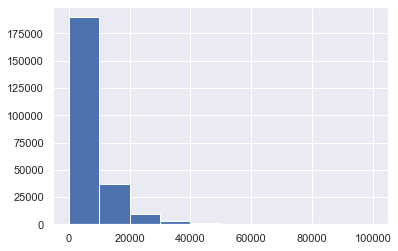

In [96]:
plt.hist(data['price'])
print()

In [ ]:
plt.hist(np.log(data['price']))
print()

In [97]:
data_drop = data[data['price']<= np.quantile(data['price'],0.99)]

In [98]:
data_drop = data_drop.reset_index()

In [99]:
data_drop.drop('index',axis=1,inplace=True)

In [100]:
for t in data_drop.dtypes.unique():
     print('Type: {}\n{}\n'.format(t, data_drop.dtypes[data_drop.dtypes==t].index.values))

Type: object
['brand' 'model' 'vehicleType' 'gearbox' 'fuelType' 'notRepairedDamage']

Type: int64
['powerPS' 'kilometer' 'autoAgeMonths' 'price']



In [101]:
categorical = []
numeric = []
other = []

categorical = list(data_drop.dtypes[data_drop.dtypes=='object'].index.values)
numeric = list(data_drop.dtypes[data_drop.dtypes=='int64'].index.values)

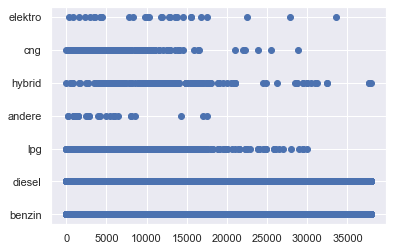

In [102]:
plt.scatter(data_drop['price'],data_drop['fuelType'])

In [103]:
data_drop['bias'] = 1
other += ['bias']

x = data_drop[categorical + numeric + other]
y = data_drop['price']

In [105]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

x = column_transformer.fit_transform(x)

In [114]:
from sklearn.model_selection import train_test_split

x_train, x_val_test, y_train, y_val_test = train_test_split(x,y, train_size=0.8)
x_test, x_val,y_test,y_val = train_test_split(x_val_test, y_val_test, train_size = 0.5)

## Задание 5. Сравнение методов градиентного спуска (2 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

### Задание 5.1. Подбор оптимальной длины шага (1 балл)

Подберите по валидационной выборке наилучшую длину шага $\lambda$ для каждого метода с точки зрения ошибки. Для этого сделайте перебор по логарифмической сетке. Для каждого метода посчитайте ошибку на обучающей и тестовой выборках, посчитайте качество по метрике $R^2$, сохраните количество итераций до сходимости.

Все параметры кроме `lambda_` стоит выставить равным значениям по умолчанию.

In [147]:
from sklearn.metrics import r2_score
descent_config = {
    'descent_name': 'full',
    'kwargs': {
        'dimension': 310,
    }
}

losses_val = []
r_sq = []
iterat = []
losses_test = []

lamd = [0.0001, 0.001, 0.01, 0.1, 1]

for i in lamd:
    descent_config['kwargs']['lambda_']=i
    model = LinearRegression(descent_config)
    model.fit(x,y)
    losses_val.append(model.calc_loss(x_val,y_val))
    r_sq.append(r2_score(y,model.predict(x)))
    iterat.append(len(model.loss_history))
    losses_test.append(model.calc_loss(x_test,y_test))

0.0001
0.001
0.01
0.1
1


In [148]:
losses_val

[82344676.79354203,
 61582712.914388865,
 7501829.977449925,
 450621.39595469553,
 4688.3130796790165]

In [149]:
r_sq

[-0.8934126842937775,
 -0.4155628425059239,
 0.8296187437398785,
 0.989888033121488,
 0.9998946080046348]

In [143]:
iterat

[301, 301, 301, 301, 301]

In [150]:
losses_test

[83025350.23470725,
 62089950.05864411,
 7478895.443551947,
 441130.78626044263,
 4958.711599797716]

### Задание 5.2. Сравнение методов (1 балла) 

Постройте график зависимости ошибки на обучающей выборке от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты (таблички с метриками и график). Сравните методы между собой.

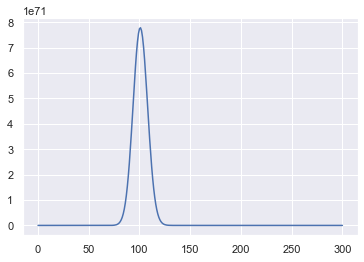

In [158]:
descent_config['kwargs']['lambda_']=3
model = LinearRegression(descent_config)
model.fit(x,y)
plt.plot(np.arange(len(model.loss_history)),model.loss_history)

## Задание 6. Стохастический градиентный спуск и размер батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска. 

* Сделайте по несколько запусков (например, k = 10) стохастического градиентного спуска на обучающей выборке для каждого размера батча из перебираемого списка. Замерьте время в секундах и количество итераций до сходимости. Посчитайте среднее этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча.
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

In [183]:
import time

batch_sizes = np.arange(5, 500, 10)
timee = []
iterat = []

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': 310,
    }
}

for i in batch_sizes[10:40]:
    t = []
    it = []
    for j in range(4):
        descent_config['kwargs']['batch_size']=i
        model = LinearRegression(descent_config,max_iter=300)
        start_time = time.time()
        model.fit(x,y)
        t.append(time.time() - start_time)
        it.append(len(model.loss_history))
    timee.append(np.mean(t))
    iterat.append(np.mean(it))
    t.clear()
    it.clear()

105 [301, 301, 301, 301]
115 [301, 301, 301, 301]
125 [301, 301, 301, 301]
135 [301, 301, 301, 301]
145 [301, 301, 301, 301]
155 [301, 301, 301, 301]
165 [301, 301, 301, 301]
175 [301, 301, 301, 301]
185 [301, 301, 301, 301]
195 [301, 301, 301, 301]
205 [301, 301, 301, 301]
215 [301, 301, 301, 301]
225 [301, 301, 301, 301]
235 [301, 301, 301, 301]
245 [301, 301, 301, 301]
255 [301, 301, 301, 301]
265 [301, 301, 301, 301]
275 [301, 301, 301, 301]
285 [301, 301, 301, 301]
295 [301, 301, 301, 301]
305 [301, 301, 301, 301]
315 [301, 301, 301, 301]
325 [301, 301, 301, 301]
335 [301, 301, 301, 301]
345 [301, 301, 301, 301]
355 [301, 301, 301, 301]
365 [301, 301, 301, 301]
375 [301, 301, 301, 301]
385 [301, 301, 301, 301]
395 [301, 301, 301, 301]


In [ ]:
plt.plot(batch_sizes,timee)

In [ ]:
plt.plot(batch_sizes,iterat)

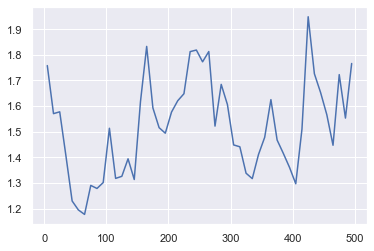

In [181]:
plt.plot(batch_sizes,timee)

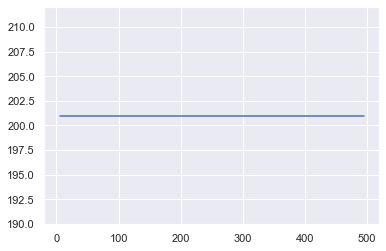

In [182]:
plt.plot(batch_sizes,iterat)

## Задание 7. Регуляризация (1 балл)

В этом задании вам предстоит исследовать влияние регуляризации на работу различных методов градиентного спуска. Напомним, регуляризация - это добавка к функции потерь, которая штрафует за норму весов. Мы будем использовать l2 регуляризацию, таким образом функция потерь приобретает следующий вид:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2 + \dfrac{\mu}{2} \| w \|^2
$$

Допишите класс **BaseDescentReg** в файле `descents.py`.

Протестируйте ваше решение в контесте.

Вставьте ссылку на успешную посылку:

* **BaseDescentReg**:

Найдите лучшие параметры обучения с регуляризацией аналогично 5 заданию. Будем подбирать длину шага $\lambda$ (`lambda_`) и коэффициент регуляризации $\mu$ (`mu`).

Сравните для каждого метода результаты с регуляризацией и без регуляризации (нужно опять сохранить ошибку и качество по метрике $R^2$ на обучающей и тестовой выборках и количество итераций до сходимости).

Постройте для каждого метода график со значениями функции потерь MSE с регуляризацией и без регуляризации (всего должно получиться 4 графика).

Посмотрите на получившиеся результаты. Какие можно сделать выводы, как регуляризация влияет на сходимость? Как изменилось качество на обучающей выборке? На тестовой? Чем вы можете объяснить это?

In [188]:
from sklearn.metrics import r2_score
descent_config = {
    'descent_name': 'full',
    'regularized' : True,
    'kwargs': {
        'dimension': 310,
    }
}

losses_val = []
r_sq = []
iterat = []
losses_test = []

lamd = [0.0001, 0.001, 0.01, 0.1, 1]
mu = [0.001, 0.01, 0.1, 1,4]

for i in lamd:
    for m in mu: 
        descent_config['kwargs']['lambda_']=i
        descent_config['kwargs']['mu']=m
        model = LinearRegression(descent_config)
        model.fit(x,y)
        losses_val.append(model.calc_loss(x_val,y_val))
        r_sq.append(r2_score(y,model.predict(x)))
        iterat.append(len(model.loss_history))
        losses_test.append(model.calc_loss(x_test,y_test))

In [ ]:
r = np.array([losses_test])

In [198]:
mu

[0.001, 0.01, 0.1, 1, 4]

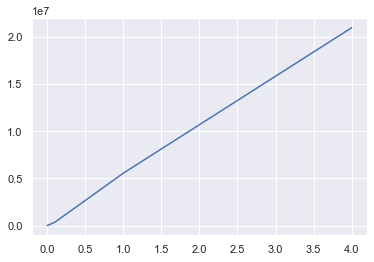

In [216]:
plt.plot(mu,losses_val[20:25])

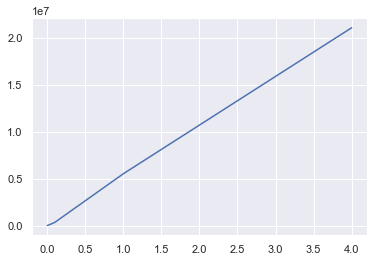

In [217]:
plt.plot(mu,losses_test[20:25])